In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from scipy.signal import find_peaks
import pims
import trackpy as tp
from scipy.interpolate import griddata

from utils.utils import extract_frames_from_video, get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import griddata
# from scipy.ndimage import gaussian_filter

# def compute_vorticity_from_irregular_data(x, y, dx, dy, grid_size=(1080, 1980), smoothing_sigma=0):
#     """
#     Compute vorticity from irregularly spaced x, y coordinates and dx, dy displacements.

#     Parameters:
#     - x, y: 1D arrays of coordinates
#     - dx, dy: 1D arrays of displacements
#     - grid_size: Tuple (H, W) specifying the grid size for interpolation
#     - smoothing_sigma: Standard deviation for Gaussian smoothing (optional)

#     Returns:
#     - X, Y: 2D meshgrid arrays
#     - vorticity: 2D array of vorticity values
#     """

#     # Define the regular grid
#     H, W = grid_size
#     x_grid = np.linspace(np.min(x), np.max(x), W)
#     y_grid = np.linspace(np.min(y), np.max(y), H)
#     X, Y = np.meshgrid(x_grid, y_grid)

#     # Interpolate dx and dy onto the regular grid
#     U = griddata((x, y), dx, (X, Y), method='cubic', fill_value=np.nan)
#     V = griddata((x, y), dy, (X, Y), method='cubic', fill_value=np.nan)

#     # Mask NaN values to avoid propagation in gradient calculations
#     U = np.ma.masked_invalid(U)
#     V = np.ma.masked_invalid(V)

#     # Compute the derivatives of the velocity field
#     dVdx = np.gradient(V, axis=1) / (x_grid[1] - x_grid[0])
#     dUdy = np.gradient(U, axis=0) / (y_grid[1] - y_grid[0])

#     # Calculate the vorticity
#     vorticity = dVdx - dUdy

#     # Apply Gaussian smoothing to the vorticity field if needed
#     if smoothing_sigma > 0:
#         vorticity = gaussian_filter(vorticity.filled(np.nan), sigma=smoothing_sigma)
#         vorticity = np.ma.masked_invalid(vorticity)

#     return X, Y, vorticity

# # Example data (replace with actual experimental data)
# x = np.random.uniform(0, 4 * np.pi, 10000)
# y = np.random.uniform(0, 4 * np.pi, 10000)
# dx = np.sin(x) * np.cos(y) + 0.5 * np.cos(x / 2) * np.sin(y / 2) + 0.5 * np.random.randn(10000)
# dy = -np.cos(x) * np.sin(y) + 0.5 * np.sin(x / 2) * np.cos(y / 2) + 0.5 * np.random.randn(10000)

# # Compute vorticity
# grid_size = (1080, 1980)
# smoothing_sigma = 10
# X, Y, vorticity = compute_vorticity_from_irregular_data(x, y, dx, dy, grid_size, smoothing_sigma)

# # Verify the range of vorticity values
# vorticity_min, vorticity_max = np.min(vorticity), np.max(vorticity)
# print(f"Vorticity range: {vorticity_min} to {vorticity_max}")

# # Plot the vorticity field
# plt.figure(figsize=(10, 8))
# vmin = np.percentile(vorticity.compressed(), 10)
# vmax = np.percentile(vorticity.compressed(), 90)
# plt.imshow(vorticity, extent=(X.min(), X.max(), Y.min(), Y.max()), cmap='seismic', vmin=vmin, vmax=vmax)
# plt.colorbar(label='Vorticity')
# plt.title('Vorticity Field')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()


In [9]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0412_123556_156.MP4"
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename); print("vid properties: ", vid_props)
fps = vid_props[0]

# Scale D-LOW
pixel_per_real_width =  2.127659
mpp = 0.47
print("D low - FHD, pixel_per_real_width = ", pixel_per_real_width)


# PIMs load in
EXPORT_FRAMES = False
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
extract_frames_from_video(vid_path, vid_filename, frames_filepaths) if EXPORT_FRAMES else None
img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder)) 
img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))

xy_real_step = 750
xy_px_step = xy_real_step * mpp 
ax_params = {
    "xticks" : np.arange(0,img_width, xy_px_step, dtype=int),
    "xticklabels" : np.arange(0, (img_width / mpp), xy_real_step, dtype=int),
    "yticks" : np.arange(img_height, 0, -xy_px_step, dtype=int),
    "yticklabels" : np.arange(0, (img_height / mpp), xy_real_step, dtype=int),
    "xlabel" : "X (µm)", "ylabel" : "Y (µm)",
}
print(ax_params)
# Save figures
results_path = "./data/results/vortex/"
save_figure_path = os.path.join(results_path, vid_filename.split(".MP4")[0])
os.makedirs(save_figure_path, exist_ok=True)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# Time vector
time = np.linspace(0, len(frames) / fps, len(frames))  # in seconds
ttrigger = 10  # seconds
time_idx = np.where(time >= ttrigger)[0][0]
ttime = time[:time_idx]
num_frames = time_idx

print("selected time num_frames=", num_frames, "trigger time start-end", np.round(ttime[0]), np.round(ttime[-1]),"\n all frames", frames)

vid properties:  (60, 2238, 1920, 1080)
D low - FHD, pixel_per_real_width =  2.127659
real width (µm):  4085.11 
real height (µm): 2297.87
{'xticks': array([   0,  352,  704, 1056, 1408, 1760]), 'xticklabels': array([   0,  750, 1500, 2250, 3000, 3750]), 'yticks': array([1080,  727,  374,   21]), 'yticklabels': array([   0,  750, 1500, 2250]), 'xlabel': 'X (µm)', 'ylabel': 'Y (µm)'}
selected time num_frames= 600 trigger time start-end 0.0 10.0 
 all frames (ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0412_123556_156/*.jpg
    Length: 2238 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8


# Z Projection over time

In [5]:
subtract_frame_idx = 0
subtract_frame = frames[subtract_frame_idx]
process_frames = np.arange(subtract_frame_idx + 1, 1800)#num_frames)

# zproj = []
# for nth in process_frames:
#     zproj.append(frames[nth] - subtract_frame)
# zproj = np.stack(zproj)
# zproj = np.min(zproj, axis=0)

SAVE_NPY = False
if SAVE_NPY:
    np.save(f"{save_figure_path}/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy", zproj)
else:
    zproj = np.load(f"{save_figure_path}/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy")


-173.9221 25.000000000000014 [-121.3529  -92.8538  -79.8538  -67.296     0.    ]


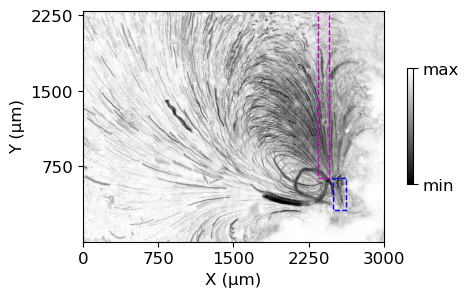

In [13]:
SAVE_FIGURES = True

print(np.min(zproj), np.max(zproj), np.percentile(zproj, [.1, 1, 2.5, 5, 95]))
vmin_ = np.percentile(zproj, .1)
vmax_ = 0
# R and D bbox
rotifer_bbox = [1170, 1230, 780, 930]
filter_box = [1100, 1150, 0, 780]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
cax = ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
ax.set(**ax_params); #ax.invert_yaxis();
ax.set(xlim=(0,1408))
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[vmax_, vmin_], yticklabels=["max", "min"])
plot_bbox(filter_box, c="m", ax=ax)
plot_bbox(rotifer_bbox, c="b", ax=ax)

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-scale.jpg", **fig_params) if SAVE_FIGURES else None


# HAVE TO FILTER OUT ROTIFER AND OTHER STUFF, THEN SAVE AGAIN!

# Locate features
- on feature level exclude around rot (tight) and the obsticle

n features -  1369


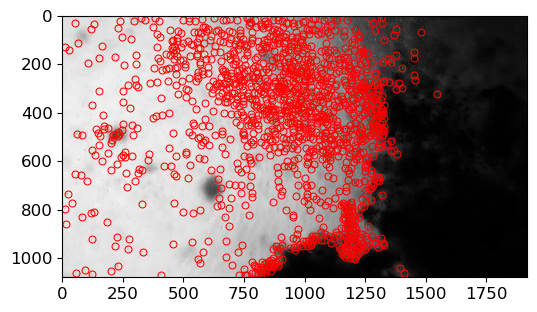

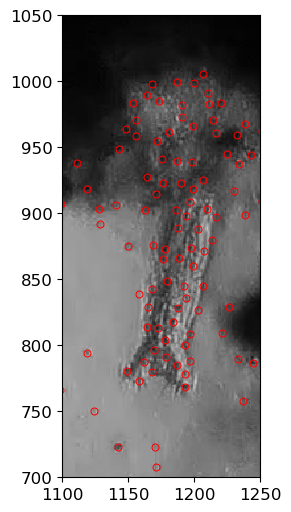

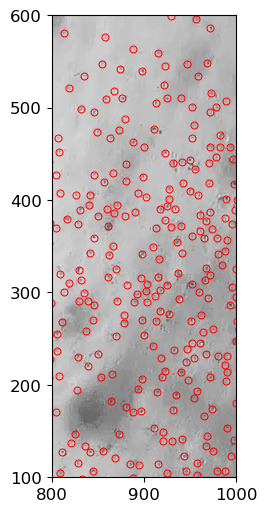

In [14]:
locate_params = {
    "diameter" : 7,
    "threshold" : 3,
    "invert" : True,
}
frame_nr = 0

# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

fig, ax = plt.subplots(figsize=(6,6))
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});

fig, ax = plt.subplots(figsize=(6,6))
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax.set(xlim=(1100,1250), ylim=(700, 1050));

fig, ax = plt.subplots(figsize=(6,6))
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax.set(xlim=(800,1000), ylim=(100, 600));


# 2. Batch Process frames

In [15]:
tp.quiet()
fbatch = tp.batch(frames[:1800], **locate_params)  # :600 takes ca. 2min30sec

condition1 = (fbatch.x > 1250)
fbatch = fbatch[~condition1]

condition2 = (fbatch.x > 750) & (fbatch.y > 950)
fbatch = fbatch[~condition2]

fbatch

y            x        mass      size       ecc     signal  \
0           5.751020   891.677551  190.939410  1.379145  0.235947  26.108042   
1           6.894118   524.176471   66.244285  1.132410  0.106619  11.300496   
2           7.037037   764.439815   84.169209  1.392772  0.384309  12.079840   
3           6.569444   939.666667   28.056403  0.978945  0.539903   7.014101   
5           7.922330  1043.873786  120.408730  1.202748  0.108998  20.652630   
...              ...          ...         ...       ...       ...        ...   
2803334  1063.371429    90.397143  130.159380  1.413203  0.184911  16.362894   
2803335  1062.960000   568.497143   65.079690  1.521278  0.277424   7.065795   
2803337  1063.963636   225.472727   40.907234  1.159937  0.318871   7.065795   
2803340  1068.236434    60.352713   95.946058  1.478528  0.176380  10.784634   
2803343  1071.992278   735.536680   96.317941  1.639286  0.088761   9.668983   

          raw_mass        ep  frame  
0       -4035.6129 -1.038166      0  
1       -5288.6692 -0.371492      0  
2       -4395.9877 -0.684754      0  
3       -4209.4168 -0.831254      0  
5       -3437.9350 -7.208087      0  
...            ...       ...    ...  
2803334 -5110.2920 -0.384526   1799  
2803335 -5009.8865 -0.406296   1799  
2803337 -5617.5029 -0.302613   1799  
2803340 -5212.7079 -0.364598   1799  
2803343 -4283.8082 -0.687970   1799  

[2460030 rows x 9 columns]

In [16]:
SAVE_FBATCH = False
fbatch.to_csv(f"{save_figure_path}/fbatch_1800_frames.csv", index=False) if SAVE_FBATCH else None

# 3. Link particles / frames to trajectories

In [17]:
link_params = {
    "search_range" : 40,  # within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(fps/2); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 53532
30
N Before: 53532 
 N after filtering: 11581


In [18]:
SAVE_TRAJS = False
LOAD_TRAJS = True
trajs.to_csv(f"{save_figure_path}/trajs_1800_frames.csv", index=False) if SAVE_TRAJS else None
trajs = pd.read_csv(f"{save_figure_path}/trajs_1800_frames.csv") if LOAD_TRAJS else None

# 4. Visualize Trajectories

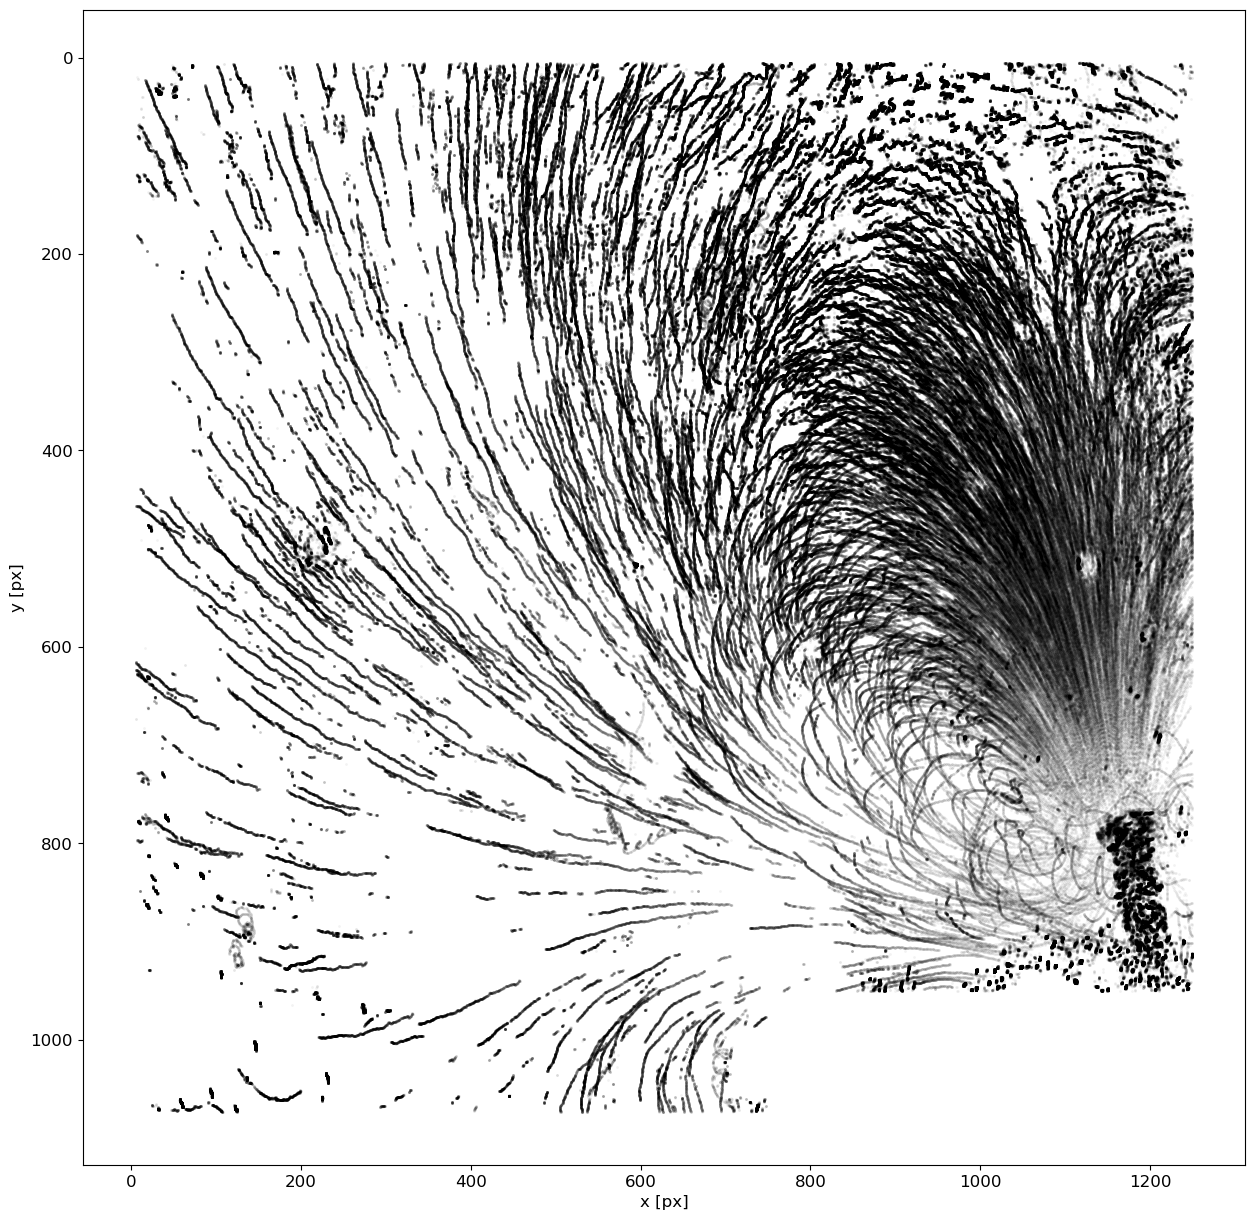

In [19]:
# fig, ax = plt.subplots()
# tp.plot_traj(trajs, superimpose=frames[time_idx], label=False, ax=ax); #ax.set(**ax_params); 

fig, ax = plt.subplots(figsize=(15,15))
tp.scatter(trajs, ax=ax, plot_style={"ms" : 1, "alpha" : .05, "color" : "k", "mfc" : "none"});

### further filtering

In [20]:
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std < 8) & (stats.y_std < 8)
reject_prts = stats.particle[reject_idx].to_numpy()

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
print("number of particles (original):", num_ori_particles, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj);

number of particles = number of trajectories: 11581
number of particles (original): 11581 
number of particles remaining: 3893
number of particles = number of trajectories: 3893


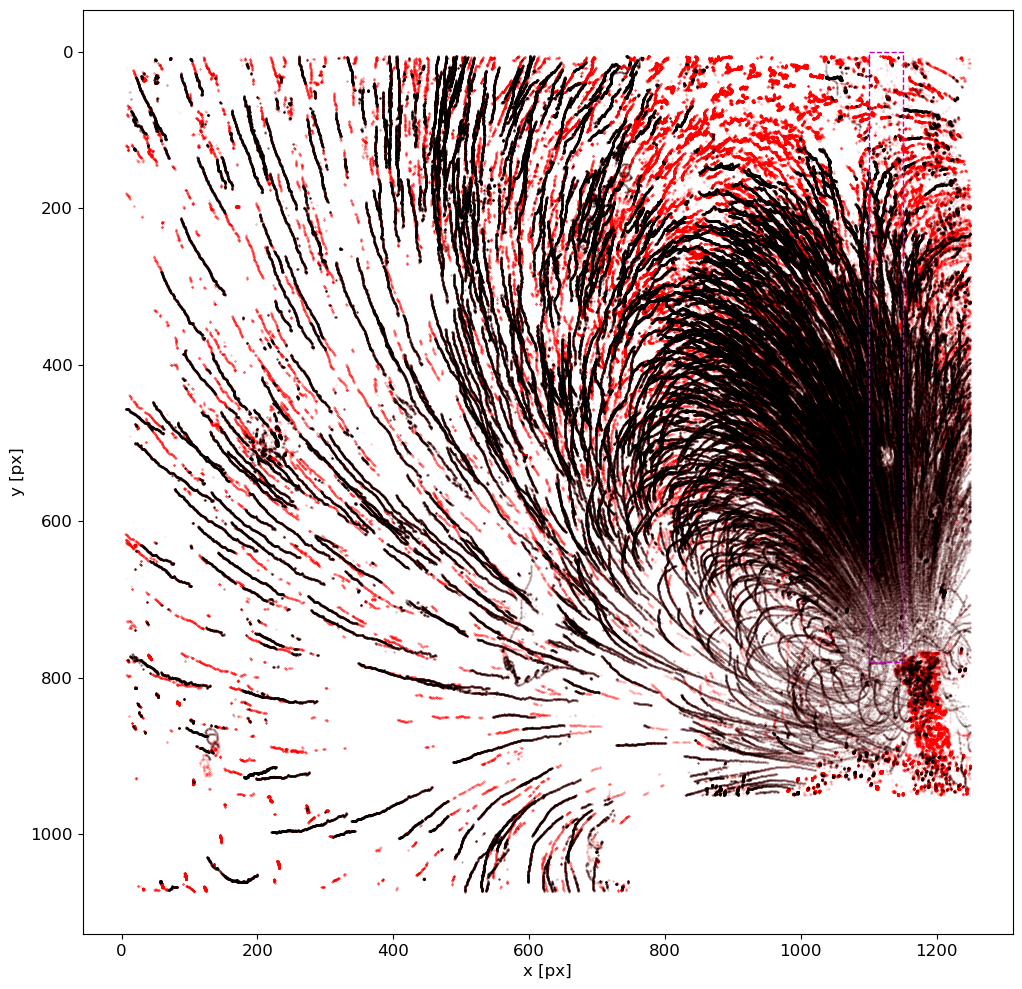

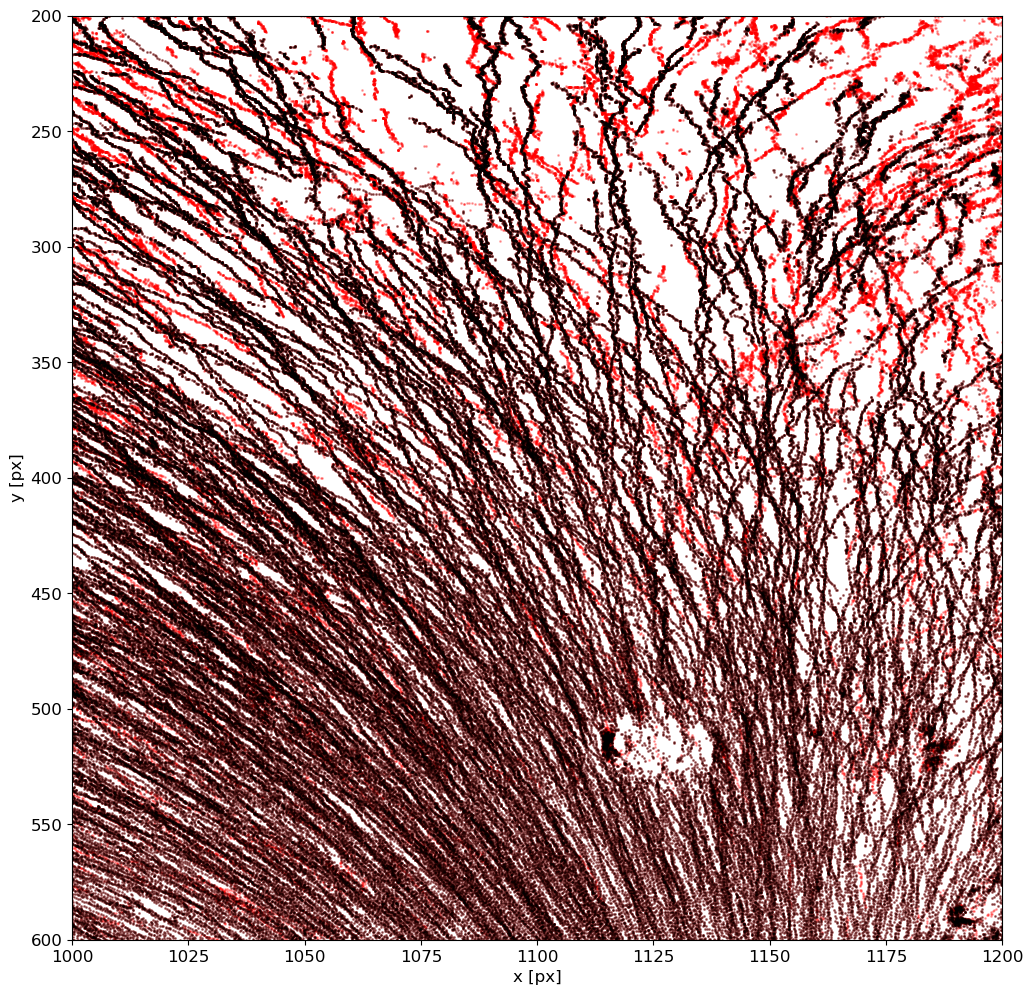

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
tp.scatter(trajs, ax=ax, plot_style={"ms" : .25, "alpha" : .1, "color" : "r"});
tp.scatter(ctraj, ax=ax, plot_style={"ms" : .5, "alpha" : .1, "color" : "k"});
filter_box = [1100, 1150, 0, 780]
plot_bbox(filter_box, c="m", ax=ax)
#ax.set(**ax_params); 

fig, ax = plt.subplots(figsize=(12,12))
tp.scatter(trajs, ax=ax, plot_style={"ms" : 1, "alpha" : .3, "color" : "r"});
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 1, "alpha" : .3, "color" : "k"});
#ax.set(**ax_params); 
ax.set(xlim=(1000, 1200),ylim=(200,600)); ax.invert_yaxis()


In [22]:
df = pd.DataFrame()
particles = ctraj.particle.unique() # all particles
#particles = is_continuous  # only continuous

for nth in particles:
    traj = ctraj.loc[ctraj["particle"] == nth]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    df_loop = pd.DataFrame(d)
    df = pd.concat([df, df_loop[1:]])

# XY coordinates
points = df[["x", "y"]].to_numpy()
#remain_idx = points[:,1] < 1040 
#points = points[remain_idx,:]

# XY Velocity at XY coordinates
velocities = df[["dx", "dy"]].to_numpy()
#velocities = velocities[remain_idx,:]

# Velocity per point
v_xy = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) * fps / mpp

percentiles vmap: 215.02828019255082 
omap 891.8665750376946


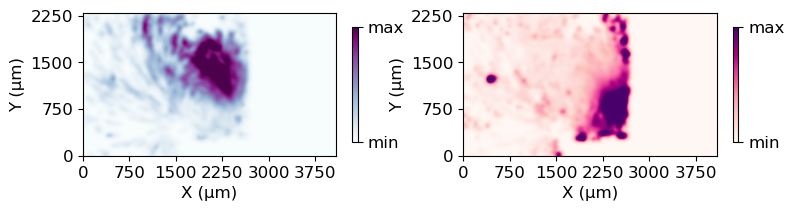

In [23]:
SAVE_FIGURES = False
bin_size_2d = 15
sigma_2d = 2

cmap = plt.cm.BuPu; cmap.set_bad(color=(0, 0, 0, 0))
cmap2 = plt.cm.RdPu; cmap2.set_bad(color=(0, 0, 0, 0)) 

occupancy_map, x_edges, y_edges = construct_occupancy_map(points, img_height, img_width, bin_size_2d)
interpolated_omap, new_x_edges, new_y_edges = interpolate_2d_map(occupancy_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
velocity_map, x_edges, y_edges = construct_velocity_map(points, v_xy, img_height, img_width, bin_size_2d, threshold_count=25)
interpolated_vmap, new_x_edges, new_y_edges = interpolate_2d_map(velocity_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)

vvmax = np.percentile(interpolated_vmap, 97.5)
ovmax = np.percentile(interpolated_omap, 97.5)

fig, ax = plt.subplots(1,2, figsize=(9, 3))
cax = ax[0].imshow(interpolated_omap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap, vmin=0, vmax=ovmax)
#plot_bbox(rotifer_bbox, "k", ax=ax[0]); plot_bbox(detritus_bbox, "k", ax=ax[0])
ax[0].set(**ax_params); ax[0].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, ovmax], yticklabels=["min", "max"])

cax = ax[1].imshow(interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap2, vmin=0, vmax=vvmax)
#plot_bbox(rotifer_bbox, "k", ax=ax[1]); plot_bbox(detritus_bbox, "k", ax=ax[1])
ax[1].set(**ax_params); ax[1].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, vvmax], yticklabels=["min", "max"])

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-occupancy-velocity-2Dmaps.jpg", **fig_params) if SAVE_FIGURES else None
print("percentiles vmap:", vvmax, "\nomap", ovmax)

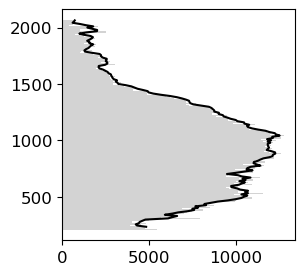

In [24]:
count, bins = np.histogram(ctraj["y"].to_numpy(), bins=np.arange(100, img_height-100, 5))
bins = bins / mpp
df_counts = pd.DataFrame(np.vstack((bins[:-1], count)).T, columns=["bins", "counts"])

fig, ax = plt.subplots(figsize=(3, 3))
ax.barh(bins[:-1], count,  height=np.diff(bins)[1], color="lightgray")
ax.plot(df_counts.counts.rolling(window=3).mean(), df_counts.bins, "-k", lw=1.5)

In [25]:
filter_box = [1100, 1150, 0, 780]
filter_condition = (ctraj.y >= 0) & (ctraj.y < 780) & (ctraj.x >= 1100) & (ctraj.x < 1150)

df_filt = pd.DataFrame()
for nth in particles:
    traj = ctraj.loc[ctraj["particle"] == nth]
    traj = traj.loc[filter_condition]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    df_loop = pd.DataFrame(d)
    df_filt = pd.concat([df_filt, df_loop[1:]])

velocities = df_filt[["dx", "dy"]].to_numpy()
df_filt["v_xy"] = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) * fps / mpp

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_98210/4171851544.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filt.groupby('y_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()


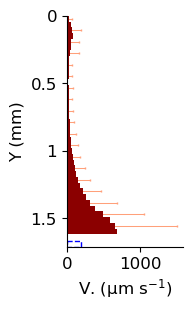

In [26]:
SAVE_FIGURES = True
bin_width = 20
bin_edges = np.arange(0, 780, bin_width)
df_filt["y_bin"] = pd.cut(df_filt["y"], bins=bin_edges)
grouped = df_filt.groupby('y_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()
medians = grouped.median()
percentile_25 = grouped.quantile(0.25)
percentile_75 = grouped.quantile(0.75)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
#bin_centers = bin_centers / mpp
bin_centers = (bin_centers) / mpp


fig, ax = plt.subplots(figsize=(1.5,3))
plt.errorbar(medians, bin_centers , xerr=[medians, percentile_75], fmt='none', ecolor='lightsalmon', elinewidth=.75, errorevery=2, capsize=1, zorder=1)
plt.barh(bin_centers, medians, height=bin_width/mpp, color="darkred", zorder=2)
plot_bbox([0, 200, 1670, 1710], c="b", ax=ax)
ax.set(ylim=(0, 1710), yticks=[0,500,1000,1500], yticklabels=[0, .5, 1, 1.5],ylabel="Y (mm)", xlabel="V. (µm s$^{-1}$)")
ax.invert_yaxis()
ax.spines[["top","right"]].set_visible(False)
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-median-velocities-histogram_.jpg", **fig_params) if SAVE_FIGURES else None

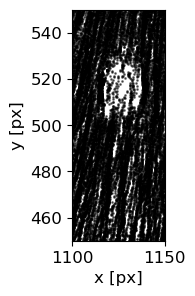

In [27]:
show_zoom = {0 : [1100, 1150, 250, 350],
             1 : [1100, 1150, 450, 550],
             2 : [1100, 1150, 650, 750]}

fig, ax = plt.subplots()
#tp.plot_traj(ctraj, ax=ax, plot_style={"lw" : 1, "color" : "k", "alpha" : .5})
tp.scatter(ctraj, ax=ax, plot_style={"color" : "k", "alpha" : .5, "ms" : 1})
ax.set(xlim=(show_zoom[1][:2]), ylim=(show_zoom[1][2:]), aspect=1.25)

df_ = pd.DataFrame()
for nth in particles:
    traj = ctraj.loc[ctraj["particle"] == nth]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    df_loop = pd.DataFrame(d)
    df_ = pd.concat([df_, df_loop[1:]])

velocities = df_[["dx", "dy"]].to_numpy()
df_["v_xy"] = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) * fps / mpp

In [ ]:
df__ = df_.sample(frac=1)
clipped = np.clip(df__.v_xy.to_numpy(), 0, 500)

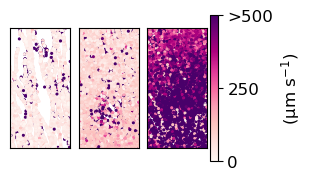

In [33]:
fig, ax = plt.subplots(1,3, figsize=(3,3), layout="constrained")
for nth, cax in enumerate(ax):
    outax = cax.scatter(df__.x, df__.y, c=clipped, cmap="RdPu", alpha=1, s=1.5);
    cax.set(xlim=(show_zoom[nth][:2]), ylim=(show_zoom[nth][2:]), aspect=1, xticks=[], yticks=[]);
    cax.invert_yaxis()

cbar = fig.colorbar(outax, shrink=.5, label="(µm s$^{-1}$)");
cbar.ax.set(yticks=[0,250,500], yticklabels=["0", "250", ">500"]);
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-scatter-velocities.jpg", **fig_params) if SAVE_FIGURES else None

In [34]:
SAVE_FIGURES

True

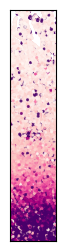

In [35]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.scatter(df__.x, df__.y, c=clipped, cmap="RdPu", alpha=.75, s=1.5)
ax.set(xlim=(show_zoom[0][:2]), ylim=(250,750), aspect=.5, xticks=[], yticks=[])
ax.invert_yaxis()
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-scatter-velocities_y-250-750_.jpg", **fig_params) if SAVE_FIGURES else None

In [ ]:
# full_frames = np.arange(3000)
# displacement_array = reindex_calculate_displacement_and_stack(ctraj, full_frames)
# displacement_array = (displacement_array / mpp * fps) / 1000
# displacement_array[displacement_array==0.0] = np.nan

# fr_time = np.arange(3000) / fps
# print(np.nanmin(displacement_array), np.nanmax(displacement_array))

# fig, ax = plt.subplots(1, 1, figsize=(3,3))
# cax = ax.imshow(displacement_array, aspect='auto', cmap="Reds", interpolation='none', vmin=0, vmax=1, extent=[0, fr_time[-1], displacement_array.shape[0], 0])
# ax.set(xlabel="Time (sec)", ylabel="Particle trajectory #")
# cbar = fig.colorbar(cax, label="Velocity (mm / sec)", shrink=.5); cbar.ax.set(yticks=(0,1), yticklabels=["0", ">1"]);
# ax.spines[["top","right"]].set_visible(False)

# fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-PIV_trajectories-vs-time.jpg", **fig_params) if SAVE_FIGURES else None

In [ ]:
full_frames = np.arange(600)
fr_time = np.arange(len(full_frames)) / fps

displacement_array = reindex_calculate_displacement_and_stack(ctraj, full_frames)
displacement_array = (displacement_array / mpp * fps) / 1000
df_disp = pd.DataFrame(displacement_array.T)
df_disp = df_disp.replace(0.0, np.nan)

selected_indices = np.arange(8)
prt_colors = ["k", "slategrey", "b", "teal", "r", "g", "m", "c", "b"]

rwindow=12
fig, ax = plt.subplots(3,1,figsize=(9,9))
for cax in ax:
    for pc, sidx in zip(prt_colors, selected_indices):
        cax.plot(fr_time, df_disp.iloc[:,sidx].rolling(window=rwindow).mean(), lw=1, color=pc, label=f"prt {sidx}");

xylim = {0 : {"ylim" : (0, 1.5)},
         1 : {"ylim" : (0, .03)},
         2 : {"ylim" : (0, .03), "xlim" : (0, 10)}}

for nth, cax in enumerate(ax):
    cax.set(xlabel="Time (sec)", ylabel="Velocity (mm/sec)", **xylim[nth])

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-velocity-vs-time_.jpg", **fig_params) if SAVE_FIGURES else None

# Velocity field calculation

In [39]:
# Define grid for velocity field
grid_x, grid_y = np.meshgrid(np.arange(0, img_width, 5), np.arange(0, img_height, 5))

# Interpolate velocities onto grid
grid_u = griddata(points, velocities[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points, velocities[:, 1], (grid_x, grid_y), method='linear')

def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy

dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)

print(np.nanmin(omega), np.nanmax(omega))

-4.019184410519241 4.397781366368318


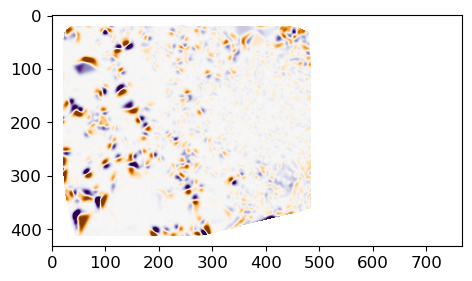

In [40]:
vort_map, _, _ = interpolate_2d_map(omega, grid_x[0,:], grid_y[:,0], scale_factor=2, method='linear', smooth=True, sigma=3)

plt.figure()
plt.imshow(vort_map, vmin=-.5,vmax=.5, cmap="PuOr", alpha=1)

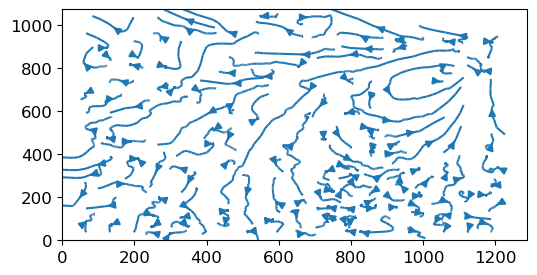

In [41]:
plt.figure()
plt.streamplot(grid_x, grid_y, grid_u, grid_v)
#plt.gca().invert_yaxis()

In [ ]:
is_continuous = list()
for nth, row in stats.iterrows():
    clist = row["frames_present"]
    if all(np.diff(clist)<=2): #any(np.diff(clist)>=2):
        is_continuous.append(nth)

print(len(is_continuous))

fig, ax = plt.subplots(1,1)
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        tp.plot_traj(traj, ax=ax, plot_style={"lw" : 1, "alpha" : .6, "color" : "k"})

In [ ]:
minmax = []
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(17,4))
ax.imshow(frames[frame_nr], cmap="gray")
# or only continuous traj, w/o frame jump, or of different diag-size
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 20)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()

#ax.set_xlim(800,1600); ax.set_ylim(0,800)
ax.invert_yaxis()
#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement.jpg", dpi=600)

### trajectory params

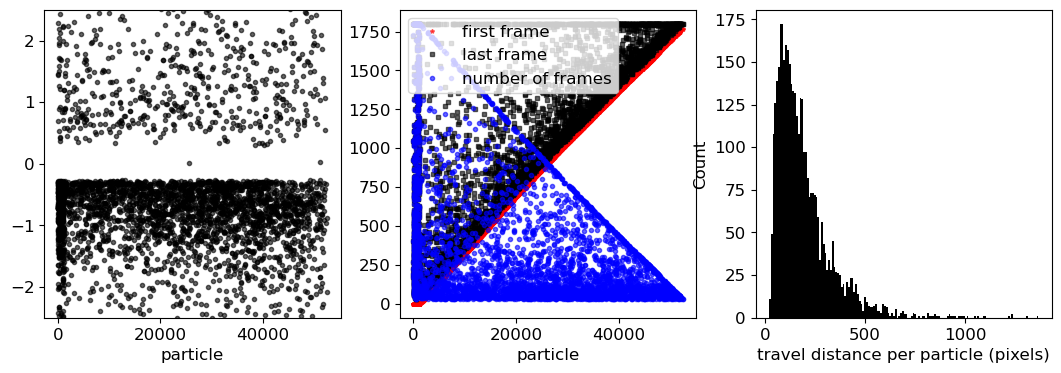

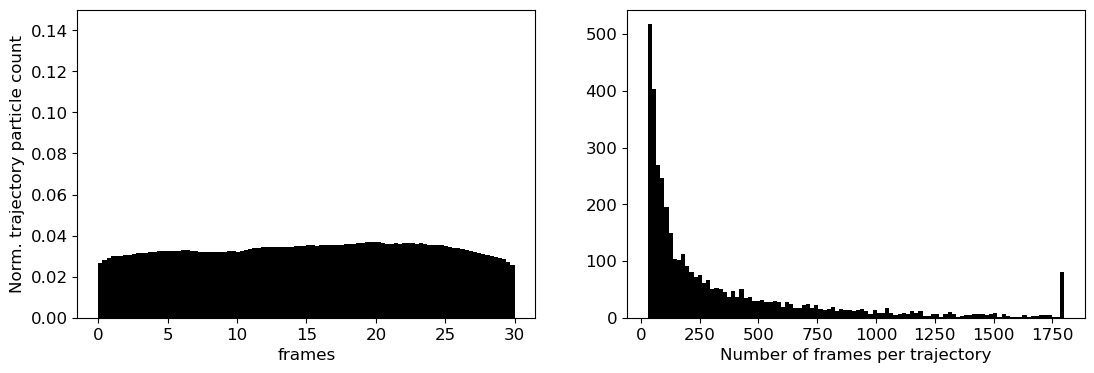

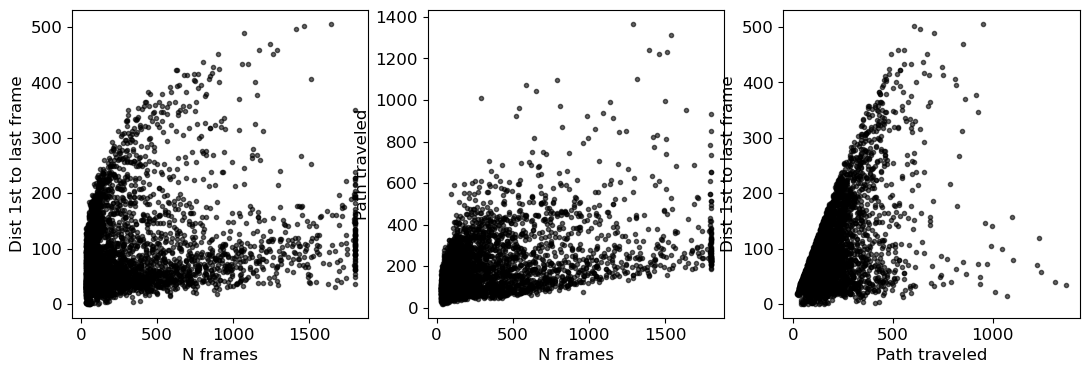

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.particle, stats.ep_median, ".k", alpha=.6)
ax[0].set_ylim(-2.5, 2.5); ax[0].set_xlabel("particle");

ax[1].plot(stats.particle, stats.first_frame, "*r", ms=3, alpha=.6, label="first frame")
ax[1].plot(stats.particle, stats.last_frame, "sk", ms=3, alpha=.6, label="last frame")
ax[1].plot(stats.particle, stats.nframes, "ob", ms=3, alpha=.6, label="number of frames")
ax[1].set_xlabel("particle");
ax[1].legend()

ax[2].hist(stats.travel_dist, bins=150, color="k");
ax[2].set_xlabel("travel distance per particle (pixels)");
ax[2].set_ylabel("Count"); #ax[2].set_xlim(0, 1500);


fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].hist(frames_present / 60, bins=100, density=True, color="k");
ax[0].set_xlabel("frames"); ax[0].set_ylabel("Norm. trajectory particle count");
ax[0].set_ylim(0, .15); #ax[0].set_xlim(0, 1050);


ax[1].hist(stats.nframes, bins=100, color="k");
ax[1].set_xlabel("Number of frames per trajectory")
#ax[1].set_xlim(0, 300);

fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.nframes, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[0].set_xlabel("N frames"); ax[0].set_ylabel("Dist 1st to last frame")

ax[1].plot(stats.nframes, stats.travel_dist, "ko", ms=3, alpha=.6)
ax[1].set_xlabel("N frames"); ax[1].set_ylabel("Path traveled")

ax[2].plot(stats.travel_dist, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[2].set_xlabel("Path traveled"); ax[2].set_ylabel("Dist 1st to last frame");